[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/GNN/blob/main/GAN.ipynb)

# Installations

In [2]:
!pip install rdkit
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:00


# Imports

In [3]:
import torch
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [4]:
from torch_geometric.datasets import MoleculeNet # importing molecule-net from torch_geometric
data = MoleculeNet(root=".", name="ESOL") # loading the ESOL dataset from molecule-net

Processing...
Done!


In [5]:
# Investigating the dataset
print("Node Feature Vector Size : ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Total no. of molecules present in the dataset : ", data.len)

Node Feature Vector Size :  9
Dataset target:  734
Total no. of molecules present in the dataset :  <bound method InMemoryDataset.len of ESOL(1128)>


Smiles Code for Molecule 0 :  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 


Graphical Representation of Molecule 0 : 


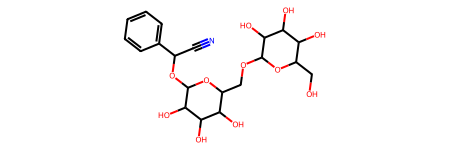

In [6]:
# Visualizing first molecule in the dataset
print("Smiles Code for Molecule 0 : ", data[0]["smiles"])
print("")
print("")


from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
print("Graphical Representation of Molecule 0 : ")
Chem.MolFromSmiles(data[0]["smiles"])

In [7]:
# Investingating first molecule in the dataset
print("Solubility of Molecule 0 : ", data[0].y)
print("")
print("")


print("No. of nodes in Molecule 0 : ", data[0].num_nodes)
print("Feature vector for each node in molecule 0 : ", data[0].x) # Shape: [num_nodes, num_node_features] = [32, 9]
print("")
print("")


print("No. of edges in Molecule 0 : ", data[0].num_edges)
print("Feature vector for each edge in molecule 0 : ", data[0].edge_index.t()) # Shape [2, num_edges] = [2,68]
print("")
print("")


print("Molecule 0 : ", data[0])

Solubility of Molecule 0 :  tensor([[-0.7700]])


No. of nodes in Molecule 0 :  32
Feature vector for each node in molecule 0 :  tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5,

# Dataloader

In [8]:
from torch_geometric.data import DataLoader
loader = DataLoader(data[:int(len(data) * 0.8)], batch_size=64, shuffle=True) # train loader - 80%
test_loader = DataLoader(data[int(len(data) * 0.8):], batch_size=64, shuffle=True) # test loader - 20%

# Modelling - Heirarchical Pooling Model

In [9]:
import torch
from torch.nn import Linear, BatchNorm1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, TransformerConv, GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

In [29]:
class Heir_GNN(torch.nn.Module):

    def __init__(self):
        super(Heir_GNN, self).__init__()

        embedding_size = 1024

        # layer 1
        self.conv1 = GATConv(data.num_features, embedding_size, heads = 3, dropout = 0.3)
        self.transf1 = Linear(embedding_size*3, embedding_size) # transform back to the node size
        self.pool1 = TopKPooling(embedding_size, ratio = 0.8)

        # layer 2
        self.conv2 = GATConv(embedding_size, embedding_size, heads = 3, dropout = 0.3)
        self.transf2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio = 0.5)

        # layer 3
        self.conv3 = GATConv(embedding_size, embedding_size, heads = 3, dropout = 0.3)
        self.transf3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio = 0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, 1)

        # Input Layer
        # emb_size_1 = 16
        # self.conv1 = TransformerConv(feature_size, emb_size_1, heads=4, dropout=0.3,
        #                             # edge_dim=edge_dim,
        #                             beta=True)
        # self.transf1 = Linear(emb_size_1*4, emb_size_1)
        # self.bn1 = BatchNorm1d(emb_size_1)

        # hidden layer 1
        # emb_size_2 = 32
        # self.conv2 = TransformerConv(emb_size_1, emb_size_2, heads=3, dropout=0.3,
        #                                         # edge_dim=edge_dim,
        #                                         beta=True)
        # self.transf2 = Linear(emb_size_2*3, emb_size_2)
        # self.bn2 = BatchNorm1d(emb_size_2)
        # self.pool2 = TopKPooling(emb_size_2, ratio=0.9)

        # hidden layer 2
        # emb_size_3 = 64
        # self.conv3 = TransformerConv(emb_size_2, emb_size_3, heads=2, dropout=0.3,
        #                                         # edge_dim=edge_dim,
        #                                         beta=True)
        # self.transf3 = Linear(emb_size_3*2, emb_size_3)
        # self.bn3 = BatchNorm1d(emb_size_3)
        # not adding pooling layer here

        # hidden layer 3
        # emb_size_4 = 128
        # self.conv4 = TransformerConv(emb_size_3, emb_size_4, heads=1, dropout=0.3,
        #                                         # edge_dim=edge_dim,
        #                                         beta=True)
        # self.transf4 = Linear(emb_size_4*1, emb_size_4)
        # self.bn4 = BatchNorm1d(emb_size_4)
        # not adding pooling layer here

    def forward(self, x, edge_index, batch_index):

        # 1
        x = self.conv1(x, edge_index)
        x = self.transf1(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)
        x1 = torch.cat([gap(x, batch_index), gap(x, batch_index)], dim = 1) # global max pooling and golab avg pooling

        # 2
        x = self.conv2(x, edge_index)
        x = self.transf2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, edge_index, None, batch_index)
        x2 = torch.cat([gap(x, batch_index), gap(x, batch_index)], dim = 1)

        # 3
        x = self.conv3(x, edge_index)
        x = self.transf3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, edge_index, None, batch_index)
        x3 = torch.cat([gap(x, batch_index), gap(x, batch_index)], dim = 1)

        # combining all 3 graphs
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        return x

# Training

In [30]:
model = Heir_GNN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Heir_GNN(
  (conv1): GATConv(9, 1024, heads=3)
  (transf1): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (transf2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (transf3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
)
Number of parameters:  17889281


In [31]:
loss_fn = torch.nn.MSELoss() # root mean squared error cause regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
model = model.to(device)
losses = []

In [32]:
for epoch in range(2000):

    for batch in loader:

      batch.to(device) # sending data to GPU

      optimizer.zero_grad() # Reset gradients

      pred = model(batch.x.float(), batch.edge_index, batch.batch) # Passing the node features and the connection info

      loss = loss_fn(pred, batch.y) # Calculating the loss and gradients

      loss.backward()

      optimizer.step() # Update using the gradients

    losses.append(loss)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Epoch 0 | Train Loss 22.83892822265625
Epoch 100 | Train Loss 6.307971000671387
Epoch 200 | Train Loss 14.935218811035156
Epoch 300 | Train Loss 7.981721878051758
Epoch 400 | Train Loss 6.195228576660156
Epoch 500 | Train Loss 1404.4384765625
Epoch 600 | Train Loss 12.015504837036133
Epoch 700 | Train Loss 17.429222106933594
Epoch 800 | Train Loss 19.736419677734375
Epoch 900 | Train Loss 10.665775299072266
Epoch 1000 | Train Loss 9.787280082702637
Epoch 1100 | Train Loss 9.836013793945312
Epoch 1200 | Train Loss 11.245467185974121
Epoch 1300 | Train Loss 10.40656852722168
Epoch 1400 | Train Loss 6.911245346069336
Epoch 1500 | Train Loss 4.012274742126465
Epoch 1600 | Train Loss 6.527932643890381
Epoch 1700 | Train Loss 1.6496204137802124
Epoch 1800 | Train Loss 1.687220573425293
Epoch 1900 | Train Loss 2.652657985687256


# Single Batch Inference































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [35]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-4.173,-3.074911
1,-1.300,-3.074911
2,-2.180,-3.074911
3,-0.660,-3.074911
4,-1.960,-3.074911
...,...,...
59,-4.522,-3.074911
60,-1.520,-3.074911
61,0.020,-3.074911
62,-2.518,-3.074911
